# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

Found mnist Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

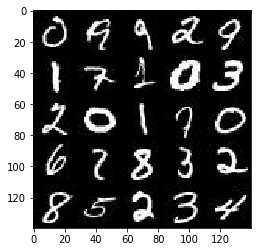

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

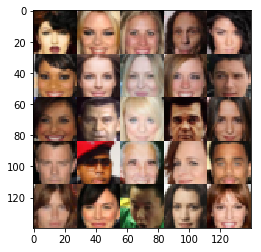

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [51]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [52]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(0.01 * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.01 * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.01 * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [70]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7,7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.01*x1, x1)
        #print(x1)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.01*x2, x2)
        #print(x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.01*x3, x3)
        #print(x3)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
        #print(logits)
        out = tf.tanh(logits)
        #print(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [72]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [73]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        # Optimize
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [74]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [104]:
def show_losses(losses):
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [79]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print("Start training ...")
    out_channel_dim = 3 if data_image_mode == "RGB" else 1
    
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    losses = []
    
    iteration = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                iteration += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if iteration % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    losses.append((train_loss_d, train_loss_g))
                    
                    print("Epoch {}/{}, iteration {}:".format(epoch_i + 1, epochs, iteration),
                          "Discriminator Loss: {:.4f},".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))


            show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
        
    print("Trainging finished")
    
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Start training ...
Epoch 1/5, iteration 10: Discriminator Loss: 0.7933, Generator Loss: 3.5645
Epoch 1/5, iteration 20: Discriminator Loss: 0.1663, Generator Loss: 6.7973
Epoch 1/5, iteration 30: Discriminator Loss: 0.7151, Generator Loss: 3.3710
Epoch 1/5, iteration 40: Discriminator Loss: 1.5533, Generator Loss: 0.6329
Epoch 1/5, iteration 50: Discriminator Loss: 1.3501, Generator Loss: 1.0902
Epoch 1/5, iteration 60: Discriminator Loss: 1.4062, Generator Loss: 0.5644
Epoch 1/5, iteration 70: Discriminator Loss: 1.0705, Generator Loss: 2.4039
Epoch 1/5, iteration 80: Discriminator Loss: 0.8218, Generator Loss: 1.5620
Epoch 1/5, iteration 90: Discriminator Loss: 1.3283, Generator Loss: 0.5724
Epoch 1/5, iteration 100: Discriminator Loss: 1.3816, Generator Loss: 0.4262
Epoch 1/5, iteration 110: Discriminator Loss: 1.1086, Generator Loss: 0.8564
Epoch 1/5, iteration 120: Discriminator Loss: 1.1548, Generator Loss: 0.8812
Epoch 1/5, iteration 130: Discriminator Loss: 1.6794, Generator Lo

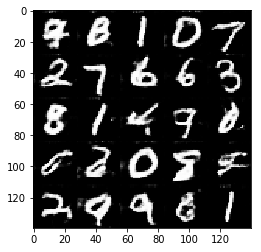

Epoch 2/5, iteration 940: Discriminator Loss: 1.0030, Generator Loss: 2.1650
Epoch 2/5, iteration 950: Discriminator Loss: 1.3353, Generator Loss: 0.4632
Epoch 2/5, iteration 960: Discriminator Loss: 1.1381, Generator Loss: 1.0378
Epoch 2/5, iteration 970: Discriminator Loss: 1.0304, Generator Loss: 0.7740
Epoch 2/5, iteration 980: Discriminator Loss: 1.0028, Generator Loss: 0.9402
Epoch 2/5, iteration 990: Discriminator Loss: 1.3435, Generator Loss: 0.4441
Epoch 2/5, iteration 1000: Discriminator Loss: 1.7359, Generator Loss: 0.2801
Epoch 2/5, iteration 1010: Discriminator Loss: 0.9139, Generator Loss: 0.9936
Epoch 2/5, iteration 1020: Discriminator Loss: 1.1472, Generator Loss: 0.6123
Epoch 2/5, iteration 1030: Discriminator Loss: 0.9868, Generator Loss: 1.4620
Epoch 2/5, iteration 1040: Discriminator Loss: 1.2200, Generator Loss: 0.5592
Epoch 2/5, iteration 1050: Discriminator Loss: 1.4778, Generator Loss: 0.4416
Epoch 2/5, iteration 1060: Discriminator Loss: 1.4747, Generator Loss:

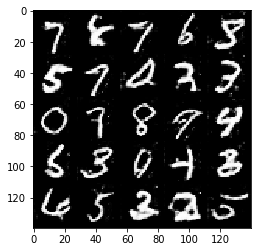

Epoch 3/5, iteration 1880: Discriminator Loss: 0.8620, Generator Loss: 0.9141
Epoch 3/5, iteration 1890: Discriminator Loss: 0.8948, Generator Loss: 0.8304
Epoch 3/5, iteration 1900: Discriminator Loss: 1.2841, Generator Loss: 0.5158
Epoch 3/5, iteration 1910: Discriminator Loss: 0.8070, Generator Loss: 2.6075
Epoch 3/5, iteration 1920: Discriminator Loss: 1.0491, Generator Loss: 0.6125
Epoch 3/5, iteration 1930: Discriminator Loss: 0.9845, Generator Loss: 0.7873
Epoch 3/5, iteration 1940: Discriminator Loss: 1.1582, Generator Loss: 0.5787
Epoch 3/5, iteration 1950: Discriminator Loss: 0.7357, Generator Loss: 1.3246
Epoch 3/5, iteration 1960: Discriminator Loss: 0.7233, Generator Loss: 0.9938
Epoch 3/5, iteration 1970: Discriminator Loss: 1.0050, Generator Loss: 0.8735
Epoch 3/5, iteration 1980: Discriminator Loss: 1.2716, Generator Loss: 0.4594
Epoch 3/5, iteration 1990: Discriminator Loss: 0.8997, Generator Loss: 0.8916
Epoch 3/5, iteration 2000: Discriminator Loss: 0.7685, Generator

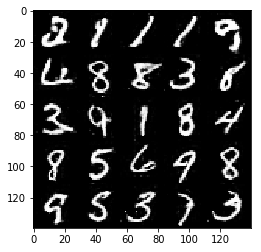

Epoch 4/5, iteration 2820: Discriminator Loss: 1.0093, Generator Loss: 0.7919
Epoch 4/5, iteration 2830: Discriminator Loss: 0.7667, Generator Loss: 1.0509
Epoch 4/5, iteration 2840: Discriminator Loss: 1.2060, Generator Loss: 0.5007
Epoch 4/5, iteration 2850: Discriminator Loss: 0.8599, Generator Loss: 1.0638
Epoch 4/5, iteration 2860: Discriminator Loss: 0.9849, Generator Loss: 0.8013
Epoch 4/5, iteration 2870: Discriminator Loss: 0.9498, Generator Loss: 0.9617
Epoch 4/5, iteration 2880: Discriminator Loss: 0.5985, Generator Loss: 1.7127
Epoch 4/5, iteration 2890: Discriminator Loss: 1.5068, Generator Loss: 0.4282
Epoch 4/5, iteration 2900: Discriminator Loss: 0.8699, Generator Loss: 0.9965
Epoch 4/5, iteration 2910: Discriminator Loss: 0.9738, Generator Loss: 0.7977
Epoch 4/5, iteration 2920: Discriminator Loss: 1.9640, Generator Loss: 0.3057
Epoch 4/5, iteration 2930: Discriminator Loss: 1.0037, Generator Loss: 0.6747
Epoch 4/5, iteration 2940: Discriminator Loss: 1.7682, Generator

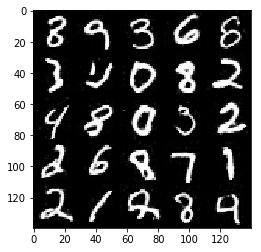

Epoch 5/5, iteration 3750: Discriminator Loss: 0.7092, Generator Loss: 1.0992
Epoch 5/5, iteration 3760: Discriminator Loss: 1.9135, Generator Loss: 0.2912
Epoch 5/5, iteration 3770: Discriminator Loss: 0.8270, Generator Loss: 0.9700
Epoch 5/5, iteration 3780: Discriminator Loss: 0.5361, Generator Loss: 1.4177
Epoch 5/5, iteration 3790: Discriminator Loss: 2.2181, Generator Loss: 0.2481
Epoch 5/5, iteration 3800: Discriminator Loss: 0.8837, Generator Loss: 1.1195
Epoch 5/5, iteration 3810: Discriminator Loss: 2.2884, Generator Loss: 0.2119
Epoch 5/5, iteration 3820: Discriminator Loss: 0.6735, Generator Loss: 1.1826
Epoch 5/5, iteration 3830: Discriminator Loss: 1.9423, Generator Loss: 0.3283
Epoch 5/5, iteration 3840: Discriminator Loss: 1.3064, Generator Loss: 0.5480
Epoch 5/5, iteration 3850: Discriminator Loss: 1.9702, Generator Loss: 4.5678
Epoch 5/5, iteration 3860: Discriminator Loss: 0.7103, Generator Loss: 0.9596
Epoch 5/5, iteration 3870: Discriminator Loss: 0.6682, Generator

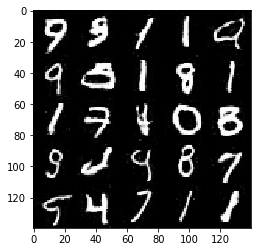

Trainging finished


In [111]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Start training ...
Epoch 1/10, iteration 10: Discriminator Loss: 0.0356, Generator Loss: 16.1200
Epoch 1/10, iteration 20: Discriminator Loss: 0.0347, Generator Loss: 4.3732
Epoch 1/10, iteration 30: Discriminator Loss: 3.3424, Generator Loss: 0.0478
Epoch 1/10, iteration 40: Discriminator Loss: 1.7145, Generator Loss: 0.5681
Epoch 1/10, iteration 50: Discriminator Loss: 1.1527, Generator Loss: 0.5839
Epoch 1/10, iteration 60: Discriminator Loss: 0.8506, Generator Loss: 1.0162
Epoch 1/10, iteration 70: Discriminator Loss: 1.1441, Generator Loss: 0.5238
Epoch 1/10, iteration 80: Discriminator Loss: 0.7349, Generator Loss: 1.7001
Epoch 1/10, iteration 90: Discriminator Loss: 0.8800, Generator Loss: 0.9410
Epoch 1/10, iteration 100: Discriminator Loss: 0.9638, Generator Loss: 2.1461
Epoch 1/10, iteration 110: Discriminator Loss: 1.8305, Generator Loss: 0.2650
Epoch 1/10, iteration 120: Discriminator Loss: 2.7523, Generator Loss: 0.1654
Epoch 1/10, iteration 130: Discriminator Loss: 1.1619

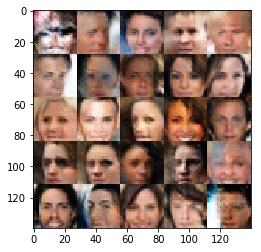

Epoch 2/10, iteration 3170: Discriminator Loss: 1.1891, Generator Loss: 0.7168
Epoch 2/10, iteration 3180: Discriminator Loss: 1.1907, Generator Loss: 1.2661
Epoch 2/10, iteration 3190: Discriminator Loss: 0.6833, Generator Loss: 1.6529
Epoch 2/10, iteration 3200: Discriminator Loss: 1.4673, Generator Loss: 0.4113
Epoch 2/10, iteration 3210: Discriminator Loss: 0.9771, Generator Loss: 0.8904
Epoch 2/10, iteration 3220: Discriminator Loss: 1.2618, Generator Loss: 0.5318
Epoch 2/10, iteration 3230: Discriminator Loss: 1.2706, Generator Loss: 0.7470
Epoch 2/10, iteration 3240: Discriminator Loss: 1.2149, Generator Loss: 0.5848
Epoch 2/10, iteration 3250: Discriminator Loss: 1.2484, Generator Loss: 0.5267
Epoch 2/10, iteration 3260: Discriminator Loss: 0.9406, Generator Loss: 1.8445
Epoch 2/10, iteration 3270: Discriminator Loss: 1.5570, Generator Loss: 0.4427
Epoch 2/10, iteration 3280: Discriminator Loss: 1.3506, Generator Loss: 0.5713
Epoch 2/10, iteration 3290: Discriminator Loss: 1.20

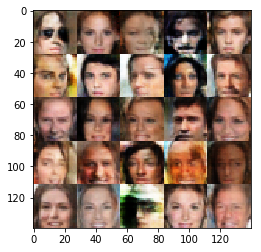

Epoch 3/10, iteration 6340: Discriminator Loss: 1.3004, Generator Loss: 1.0907
Epoch 3/10, iteration 6350: Discriminator Loss: 1.5311, Generator Loss: 0.3665
Epoch 3/10, iteration 6360: Discriminator Loss: 1.3522, Generator Loss: 0.4132
Epoch 3/10, iteration 6370: Discriminator Loss: 1.3451, Generator Loss: 0.6039
Epoch 3/10, iteration 6380: Discriminator Loss: 1.4578, Generator Loss: 0.5739
Epoch 3/10, iteration 6390: Discriminator Loss: 1.5584, Generator Loss: 0.8018
Epoch 3/10, iteration 6400: Discriminator Loss: 1.4607, Generator Loss: 0.4052
Epoch 3/10, iteration 6410: Discriminator Loss: 1.5411, Generator Loss: 0.5064
Epoch 3/10, iteration 6420: Discriminator Loss: 1.4505, Generator Loss: 0.5194
Epoch 3/10, iteration 6430: Discriminator Loss: 1.8261, Generator Loss: 0.2982
Epoch 3/10, iteration 6440: Discriminator Loss: 1.2524, Generator Loss: 0.5629
Epoch 3/10, iteration 6450: Discriminator Loss: 1.4911, Generator Loss: 0.4328
Epoch 3/10, iteration 6460: Discriminator Loss: 1.33

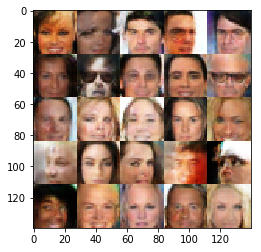

Epoch 4/10, iteration 9500: Discriminator Loss: 1.4828, Generator Loss: 0.4770
Epoch 4/10, iteration 9510: Discriminator Loss: 1.2498, Generator Loss: 0.8644
Epoch 4/10, iteration 9520: Discriminator Loss: 1.4095, Generator Loss: 0.7702
Epoch 4/10, iteration 9530: Discriminator Loss: 1.6016, Generator Loss: 0.4193
Epoch 4/10, iteration 9540: Discriminator Loss: 1.5229, Generator Loss: 0.4761
Epoch 4/10, iteration 9550: Discriminator Loss: 1.5994, Generator Loss: 0.3878
Epoch 4/10, iteration 9560: Discriminator Loss: 1.5773, Generator Loss: 0.4848
Epoch 4/10, iteration 9570: Discriminator Loss: 1.5953, Generator Loss: 0.4018
Epoch 4/10, iteration 9580: Discriminator Loss: 0.6472, Generator Loss: 1.6046
Epoch 4/10, iteration 9590: Discriminator Loss: 1.4281, Generator Loss: 0.5095
Epoch 4/10, iteration 9600: Discriminator Loss: 1.5251, Generator Loss: 0.4538
Epoch 4/10, iteration 9610: Discriminator Loss: 1.1457, Generator Loss: 0.7924
Epoch 4/10, iteration 9620: Discriminator Loss: 1.12

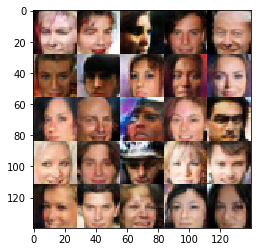

Epoch 5/10, iteration 12670: Discriminator Loss: 1.3185, Generator Loss: 0.6116
Epoch 5/10, iteration 12680: Discriminator Loss: 1.5856, Generator Loss: 0.3573
Epoch 5/10, iteration 12690: Discriminator Loss: 1.6283, Generator Loss: 0.3775
Epoch 5/10, iteration 12700: Discriminator Loss: 1.5551, Generator Loss: 0.3651
Epoch 5/10, iteration 12710: Discriminator Loss: 1.6654, Generator Loss: 0.3533
Epoch 5/10, iteration 12720: Discriminator Loss: 1.3745, Generator Loss: 0.4706
Epoch 5/10, iteration 12730: Discriminator Loss: 1.4650, Generator Loss: 0.4293
Epoch 5/10, iteration 12740: Discriminator Loss: 1.4852, Generator Loss: 0.4912
Epoch 5/10, iteration 12750: Discriminator Loss: 1.2707, Generator Loss: 0.6025
Epoch 5/10, iteration 12760: Discriminator Loss: 1.7229, Generator Loss: 0.4200
Epoch 5/10, iteration 12770: Discriminator Loss: 1.4782, Generator Loss: 0.5141
Epoch 5/10, iteration 12780: Discriminator Loss: 1.5164, Generator Loss: 0.4246
Epoch 5/10, iteration 12790: Discriminat

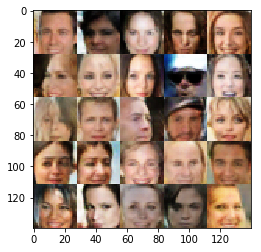

Epoch 6/10, iteration 15830: Discriminator Loss: 1.5411, Generator Loss: 0.4222
Epoch 6/10, iteration 15840: Discriminator Loss: 1.6574, Generator Loss: 0.3761
Epoch 6/10, iteration 15850: Discriminator Loss: 1.4753, Generator Loss: 0.4574
Epoch 6/10, iteration 15860: Discriminator Loss: 1.5859, Generator Loss: 0.3295
Epoch 6/10, iteration 15870: Discriminator Loss: 4.4525, Generator Loss: 4.5227
Epoch 6/10, iteration 15880: Discriminator Loss: 1.8954, Generator Loss: 0.2579
Epoch 6/10, iteration 15890: Discriminator Loss: 1.6841, Generator Loss: 0.3390
Epoch 6/10, iteration 15900: Discriminator Loss: 1.4894, Generator Loss: 0.4491
Epoch 6/10, iteration 15910: Discriminator Loss: 1.7022, Generator Loss: 0.3370
Epoch 6/10, iteration 15920: Discriminator Loss: 1.3016, Generator Loss: 0.5502
Epoch 6/10, iteration 15930: Discriminator Loss: 1.3346, Generator Loss: 0.5262
Epoch 6/10, iteration 15940: Discriminator Loss: 1.6260, Generator Loss: 0.3877
Epoch 6/10, iteration 15950: Discriminat

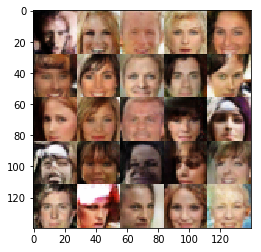

Epoch 7/10, iteration 19000: Discriminator Loss: 1.6786, Generator Loss: 0.3938
Epoch 7/10, iteration 19010: Discriminator Loss: 1.0532, Generator Loss: 0.5316
Epoch 7/10, iteration 19020: Discriminator Loss: 2.0492, Generator Loss: 0.2226
Epoch 7/10, iteration 19030: Discriminator Loss: 1.6371, Generator Loss: 0.3503
Epoch 7/10, iteration 19040: Discriminator Loss: 1.4694, Generator Loss: 0.4396
Epoch 7/10, iteration 19050: Discriminator Loss: 1.3592, Generator Loss: 0.4932
Epoch 7/10, iteration 19060: Discriminator Loss: 1.3029, Generator Loss: 0.5911
Epoch 7/10, iteration 19070: Discriminator Loss: 1.8181, Generator Loss: 0.3256
Epoch 7/10, iteration 19080: Discriminator Loss: 1.6732, Generator Loss: 0.3839
Epoch 7/10, iteration 19090: Discriminator Loss: 1.9026, Generator Loss: 0.2821
Epoch 7/10, iteration 19100: Discriminator Loss: 1.1336, Generator Loss: 0.6714
Epoch 7/10, iteration 19110: Discriminator Loss: 1.6734, Generator Loss: 0.3637
Epoch 7/10, iteration 19120: Discriminat

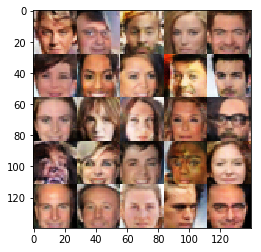

Epoch 8/10, iteration 22160: Discriminator Loss: 1.4874, Generator Loss: 0.4827
Epoch 8/10, iteration 22170: Discriminator Loss: 1.2298, Generator Loss: 0.7197
Epoch 8/10, iteration 22180: Discriminator Loss: 1.2249, Generator Loss: 1.0080
Epoch 8/10, iteration 22190: Discriminator Loss: 1.7827, Generator Loss: 0.3049
Epoch 8/10, iteration 22200: Discriminator Loss: 1.5130, Generator Loss: 0.4196
Epoch 8/10, iteration 22210: Discriminator Loss: 1.7897, Generator Loss: 0.3096
Epoch 8/10, iteration 22220: Discriminator Loss: 1.7152, Generator Loss: 0.2817
Epoch 8/10, iteration 22230: Discriminator Loss: 1.6334, Generator Loss: 0.3572
Epoch 8/10, iteration 22240: Discriminator Loss: 1.9833, Generator Loss: 0.3172
Epoch 8/10, iteration 22250: Discriminator Loss: 1.4518, Generator Loss: 0.5693
Epoch 8/10, iteration 22260: Discriminator Loss: 1.4785, Generator Loss: 0.7863
Epoch 8/10, iteration 22270: Discriminator Loss: 1.4628, Generator Loss: 0.3767
Epoch 8/10, iteration 22280: Discriminat

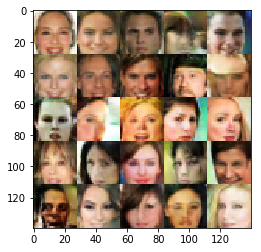

Epoch 9/10, iteration 25330: Discriminator Loss: 2.1290, Generator Loss: 0.2015
Epoch 9/10, iteration 25340: Discriminator Loss: 2.1721, Generator Loss: 0.1976
Epoch 9/10, iteration 25350: Discriminator Loss: 2.3680, Generator Loss: 0.1836
Epoch 9/10, iteration 25360: Discriminator Loss: 1.6669, Generator Loss: 0.4070
Epoch 9/10, iteration 25370: Discriminator Loss: 1.7475, Generator Loss: 0.3841
Epoch 9/10, iteration 25380: Discriminator Loss: 2.2272, Generator Loss: 0.1846
Epoch 9/10, iteration 25390: Discriminator Loss: 2.0564, Generator Loss: 0.2345
Epoch 9/10, iteration 25400: Discriminator Loss: 1.8229, Generator Loss: 0.2903
Epoch 9/10, iteration 25410: Discriminator Loss: 1.0231, Generator Loss: 1.0235
Epoch 9/10, iteration 25420: Discriminator Loss: 1.4382, Generator Loss: 0.7517
Epoch 9/10, iteration 25430: Discriminator Loss: 1.3789, Generator Loss: 0.4948
Epoch 9/10, iteration 25440: Discriminator Loss: 1.7409, Generator Loss: 0.3661
Epoch 9/10, iteration 25450: Discriminat

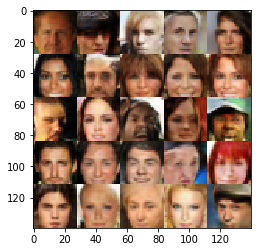

Epoch 10/10, iteration 28490: Discriminator Loss: 2.0697, Generator Loss: 0.3001
Epoch 10/10, iteration 28500: Discriminator Loss: 2.5230, Generator Loss: 0.2127
Epoch 10/10, iteration 28510: Discriminator Loss: 2.1742, Generator Loss: 0.2186
Epoch 10/10, iteration 28520: Discriminator Loss: 1.3334, Generator Loss: 0.7295
Epoch 10/10, iteration 28530: Discriminator Loss: 1.8990, Generator Loss: 0.3902
Epoch 10/10, iteration 28540: Discriminator Loss: 1.7751, Generator Loss: 0.2919
Epoch 10/10, iteration 28550: Discriminator Loss: 2.0956, Generator Loss: 0.2326
Epoch 10/10, iteration 28560: Discriminator Loss: 1.9177, Generator Loss: 0.2330
Epoch 10/10, iteration 28570: Discriminator Loss: 1.6551, Generator Loss: 0.3600
Epoch 10/10, iteration 28580: Discriminator Loss: 1.3678, Generator Loss: 0.6187
Epoch 10/10, iteration 28590: Discriminator Loss: 2.3296, Generator Loss: 0.1763
Epoch 10/10, iteration 28600: Discriminator Loss: 1.6304, Generator Loss: 0.3997
Epoch 10/10, iteration 28610

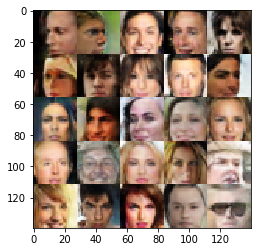

Trainging finished


In [109]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.